NOTE:  If you get error messages like `IOPub message rate exceeded.` while running this notebook, close your Jupyter instance and restart it adding the option `--NotebookApp.iopub_data_rate_limit=1.0e10`.  (As instructed [here](https://stackoverflow.com/a/44679222)).  Also try `--NotebookApp.iopub_msg_rate_limit=1.0e10`.

# Homework 3: Monte Carlo

In this assignment you will implement on-policy every-visit Monte Carlo Control and off-policy every-visit Monte Carlo Control with Weighted Importance Sampling. You will apply both of these algorithms on the frozen lake and blackjack environments and visualize their performance.

In [1]:
import copy
import itertools as itt
from collections import defaultdict
from queue import deque

import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from gym.envs.toy_text.blackjack import BlackjackEnv
from gym.envs.toy_text.frozen_lake import FrozenLakeEnv
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('ggplot')

### Setup the Environment

This assignment uses two OpenAI gym environments: the frozen lake environment and the blackjack environment. Frozen lake is a grid world where the agent must reach a goal state while avoiding holes. You can get the full description of frozen lake [here](https://gym.openai.com/envs/FrozenLake-v0/), and the full description of blackjack [here](https://gym.openai.com/envs/Blackjack-v0/).  The blackjack implementation is the same as described in Example 5.1 in [SB](http://incompleteideas.net/book/the-book-2nd.html).

In [2]:
env_blackjack = BlackjackEnv()
env_frozen_lake = FrozenLakeEnv(desc=None, map_name="4x4", is_slippery=False)

### Exercise 1 (5 pts):

Implement e-greedy action selection based on the current Q-values. Break ties between equal Q-values randomly. Remember an action should be a number in the range: [0, num_actions - 1].

In [3]:
def select_action_epsilon_greedy(Q_array, eps):
    """Perform epsilon greedy action selection based on the Q-values.
    
    Args:
        Q_array: A numpy array that contains Q-values relative to a single state.
        eps: The probability to select a random action. Float between 0 and 1.
    
    Returns:
        The selected action as an integer.
        
    Shapes:
        Q_array: `(A,)` where `A` is the number of actions.
        output: Scalar.
    """
    assert Q_array.ndim == 1
    
    #  YOUR CODE HERE:  select an action using the epsilon-greedy strategy, split ties randomly.
    num_actions = len(Q_array)
    initial_prob = np.ones(num_actions)
    random_prob = initial_prob * eps / num_actions
    opt_action = np.argmax(Q_array)
    random_prob[opt_action] = random_prob[opt_action] + (1-eps)
    action = np.random.choice(np.arange(num_actions), p = random_prob)
    return action

Implement a procedure which samples and returns a trajectory from the environment, using the epsilon-greedy agent.  The trajectory is represented by a list of (state, action, reward) tuples.

In [4]:
def sample_episode(env, Q, eps):
    """Sample an episode from the environment, using an epsilon-greedy policy based on Q.
    
    Args:
        env: The environment from which to sample episodes.
        Q: A dictionary mapping state -> action values array.
        eps: The epsilon-greedy parameter.
    
    Returns:
        transitions: A list of (state, action, reward) tuples describing the episode.
        
    Shapes:
        Q: `(A,)` Each value in Q is an array with shape `(A,)` where `A` is the number of actions.
    """
    transitions = []  # store (state, action, reward) tuples here

    # YOUR CODE HERE:  sample an episode and store it in the transitions list.
    # NOTE: the Gym interface will require you to use the following methods
    # state = env.reset()  # initialize environment and get initial state
    # state_next, reward, done, info = env.step(action)  # perform action and receive next state, reward, done flag, and additional information.
    
    # ADVICE:  have a close look at what the state is (types and values), for both problems.
    
    state = env.reset()
    done = False
    while done != True:
        state_Q_array = Q[state]
        the_action = select_action_epsilon_greedy(state_Q_array, eps)
        state_next, reward, done, info = env.step(the_action)
        transitions.append((state, the_action, reward))

        state = state_next
    
    return transitions

### Exercise 2 (10 pts):

Implement the on-policy every-visit Monte Carlo update using the incremental update formula in Section 2.3 in SB. Recall that in Chapter 2 we averaged the *rewards* whereas in MC we average the *returns*. In the formula below $G_n$ denotes the return at timestep $n$.

$$
\begin{equation}
    Q_{n+1} = Q_n + \alpha_n [G_n - Q_n]
\end{equation}
$$

In [5]:
def on_policy_every_visit_mc_control(env, num_episodes, eps, gamma):
    """Train an on-policy every-visit MC agent.
    
    Args:
        env: The environment to train the agent on.
        num_episodes: The number of episodes to train the agent for.
        eps: The probability to select a random action. Float between 0.0 and 1.0.     
        gamma: The discount factor.
        
    Returns:
        Q: a dictionary mapping state -> action values array.
        returns: an array containing the returns obtained for each episode during training.
    
    Shapes:
        Q: `(A,)` Each value in Q is an array with shape `(A,)` where `A` is the number of actions.
        returns: `(E,)` where E is the number of episodes we are using to train the agent.
    """
    
    # NOTE:  The pseudo-code in the book explicitly stores lists of returns for each (s,a) pair.
    # We want to be more memory-efficient;  so we will store counts `C` for each (s,a) pair, and use
    # the update rule in SB 2.3 to compute the same average, without having to store all the returns.

    # Create Q function dict with default values, and C (the counts) dict with default values
    Q = defaultdict(lambda: np.zeros([env.action_space.n]))
    C = defaultdict(lambda: np.zeros([env.action_space.n], dtype=np.int))

    G_queue = deque(maxlen=100)  # stores 100 most recent episode returns for diagnostics
    
    # Returns array to store episode performances
    returns = np.empty(num_episodes)

    pbar = tqdm.tnrange(num_episodes, leave=False)  # progress bar
    for i in pbar:
        G = 0.0
        
        # YOUR CODE HERE:  sample an episode, and use the transition list to compute returns and update Q and C.
        
            
        the_episode = sample_episode(env, Q, eps)
        
        backward_list = range(len(the_episode))[::-1]
        for temp in backward_list:
            the_state, the_act, the_reward = the_episode[temp][0], the_episode[temp][1], the_episode[temp][2]
            G = gamma * G + the_reward
                       
            C[the_state][the_act] +=1
            Q[the_state][the_act] = Q[the_state][the_act] + (G - Q[the_state][the_act])/C[the_state][the_act]
            
        returns[i] = G
        
        # diagnostics
        G_queue.append(G)
        pbar.set_description(f'Episodes G={sum(G_queue) / len(G_queue)}')
        
    return Q, returns

### Exercise 3 (15 pts):

a) (2 pts) Calculate the learning curve (or returns) for the frozen lake environment, averaged over 50 independent runs and 1k episodes each, using $\gamma = 1.0$ and $\epsilon = 0.5$.

In [217]:
num_runs, num_episodes = 50, 1_000
returns_fl = np.empty((num_runs, num_episodes))

for i in tqdm.tnrange(num_runs, desc='Runs'):
    # YOUR CODE HERE
    Frozen_Q, Frozen_returns = on_policy_every_visit_mc_control(env_frozen_lake, num_episodes, 0.5, 1)
    returns_fl[i] = Frozen_returns
    

b) (3 pts) Plot the resulting learning curve, averaging over the 50 runs, for the frozen lake environment.  If the results are noisy, use the following function to also plot, in the same figure, a smoother version of the same data.  Use these plots as a basis to find a better $\epsilon$ parameter, which makes the performance converge better.

In [9]:
def rolling_average(data, window_size):
    """Smoothen the 1-d data array using a rollin average.
    
    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window
        
    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(np.ones_like(data), kernel)
    return smooth_data[: -window_size + 1]

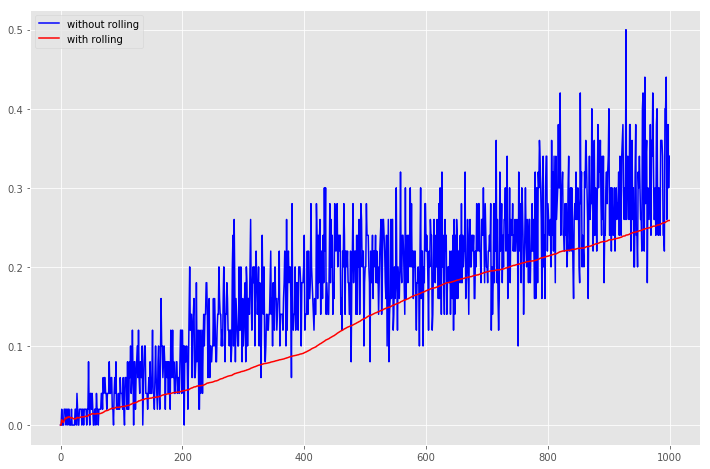

In [219]:
r_avg = np.average(returns_fl, axis=0)
rolling_avg = rolling_average(r_avg, 400)

plt.figure(figsize=(12, 8))
plt.plot(r_avg, color = 'blue', label = 'without rolling')
plt.plot(rolling_avg, color = 'red', label = 'with rolling')
plt.legend()
plt.show()

No handles with labels found to put in legend.


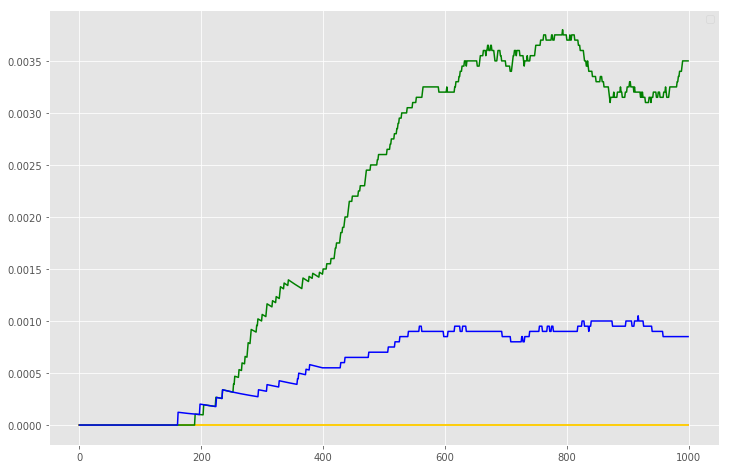

In [211]:
candidate_lambdas = [0.1, 0.3, 0.7, 0.9]
colors = ['red', 'yellow', 'green', 'blue']

plt.figure(figsize=(12, 8))
num_runs, num_episodes = 50, 1_000
for i in range(len(candidate_lambdas)):
    returns_temp_fl = np.empty((num_runs, num_episodes))
    for k in tqdm.tnrange(num_runs, desc='Runs'):
        # YOUR CODE HERE
        Frozen_temp_Q, Frozen_temp_returns = on_policy_every_visit_mc_control(env_frozen_lake, num_episodes, 
                                                                              candidate_lambdas[i], 1)
        returns_temp_fl[i] = Frozen_temp_returns
        
    r_temp_avg = np.average(returns_temp_fl, axis=0)
    temp_rolling_avg = rolling_average(r_temp_avg, 400)
    #returns_temp_fl.append(temp_rolling_avg)
    plt.plot(temp_rolling_avg, color = colors[i])

plt.show()

**Among all other 𝜖 parameters,  0.5 can give a better result to converge for frozen lake environment. Other 𝜖 can't improve it**

c) (5 pts) Compute and plot the learning curve for the blackjack environment, this time averaging 50 runs of 5k episodes each.  Again, start with $\epsilon = 0.5$, and use the resulting plots to find a better $\epsilon$ with better convergence.

In [7]:
num_runs, num_episodes = 50, 5_000
returns_bj = np.empty((num_runs, num_episodes))

for i in tqdm.tnrange(num_runs, desc='Runs'):
    # YOUR CODE HERE
    Blackjack_Q, Blackjack_returns = on_policy_every_visit_mc_control(env_blackjack, num_episodes, 0.5, 1)
    returns_bj[i] = Blackjack_returns

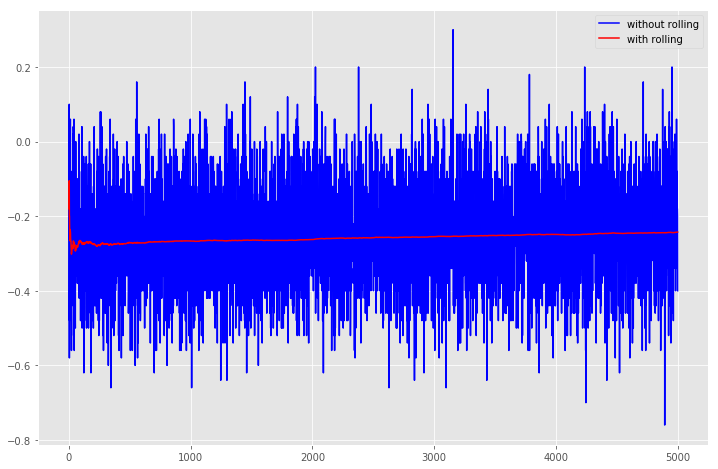

In [10]:
# YOUR CODE HERE

r_avg2 = np.average(returns_bj, axis=0)
rolling_avg2 = rolling_average(r_avg2, 2000)

plt.figure(figsize=(12, 8))
plt.plot(r_avg2, color = 'blue', label = 'without rolling')
plt.plot(rolling_avg2, color = 'red', label = 'with rolling')
plt.legend()
plt.show()

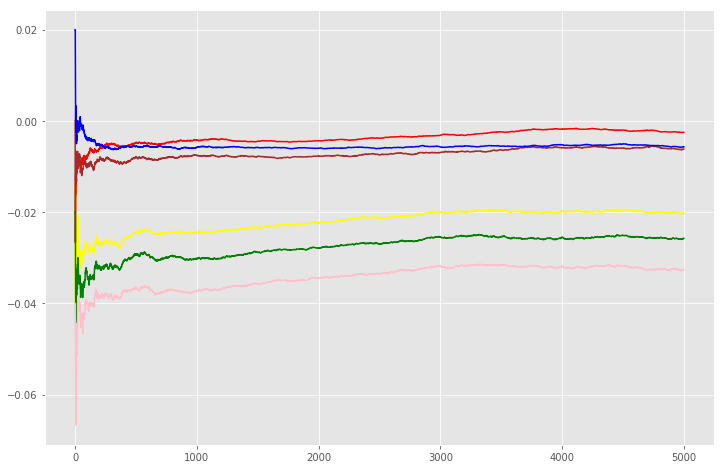

In [215]:
candidate_lambdas = [0.1, 0.2, 0.3, 0.6, 0.7, 0.8]
colors = ['red', 'yellow','brown','green', 'blue','pink']

plt.figure(figsize=(12, 8))
num_runs, num_episodes = 50, 5_000
for i in range(len(candidate_lambdas)):
    temp_returns_bj = np.empty((num_runs, num_episodes))
    for k in tqdm.tnrange(num_runs, desc='Runs'):
        # YOUR CODE HERE
        Blackjack_temp_Q, Blackjack_temp_returns = on_policy_every_visit_mc_control(env_blackjack, num_episodes, 
                                                                                    candidate_lambdas[i], 1)
        temp_returns_bj[i] = Blackjack_temp_returns
        
    r_temp_avg = np.average(temp_returns_bj, axis=0)
    temp_rolling_avg = rolling_average(r_temp_avg, 2000)
    #returns_temp_fl.append(temp_rolling_avg)
    plt.plot(temp_rolling_avg, color = colors[i])

plt.show()

**𝜖 parameter = 0.1 can give a better result to converge for Blackjack environment.**

d) (2 pts) In both environments, the learning curve can be relatively noisy, even after we have supposedly converged to the semi-optimal policy.  In general (i.e. without referring to the specific FrozenLake and BlackJack environments), why is it possible that the learning curve does not converge to a fixed value even if the policy itself has converged?

**I think this is because it always have an epsilon value. For a learning curve, it does exploration at beginning which increase the returns. But after a few runs, it does not need exploration anymore because it is already trained and have optimal action for each state. At this stage, if epsilon = 0, the learning curve may converge to a fixed value. But it is not, hence, at some probability, it'll still select other actions whose q value is randomly lower, leading to not converge.**

e) (3 pts) You may have noticed that, sometimes, the second half of a run is relatively faster than the first half.  In general (i.e. without referring to the specific FrozenLake and BlackJack environments), why does this make sense?  For which types of domains does this make sense?  Can the opposite also make sense (i.e. that the second half of a run runs slower than the first run)?  For which types of domains does this make sense?

**This makes sense since the on policy method updates the Q values for each state each action, and then making a better policy in realtime. At the first half of a run, it depends more on exploration process because the optimal Q value it selects may not be the real one. After a while on the second half of a run, the Q values are much better trained and it generates an episode that can reach the final return much faster. It makes sense for the type which only have one terminal state in the environment. The process will only end an episode when it comes to that terminal state. So if the Q values is not trained at all, it'll have a long episode before reaching the terminal state. On the contrast, if the environment have a lot of terminal states, at beginning without training Q value, the agent can easily reach a terminal state immediately and end the episode. After a few training steps, it'll try to avoid those un-optimal terminal state and take long time to reach to the final optimal terminal state. This makes sense that the second half of a run runs slower than the first run.**


### Exercise 4 (10 pts):

Run your code up to 500k episodes for the blackjack domain with a step size parameter that enables the value function to converge. Plot the value function as a color plot with a similar layout to that shown in SB Figure 5.2.  If convenient, use the given `plot_surface` function, creates a 3D plot given matrices X and Y representing the 2D function domain, and matrix Z representing the function value at those domain inputs.

In [232]:
num_episodes = 500_000
plot_Q, plot_returns = on_policy_every_visit_mc_control(env_blackjack, num_episodes, 0.5, 1)

In [250]:
def plot_surface(X, Y, Z, title):
    """Plot a 3d surface.

    Args:
        X: 2-d numpy.array indicating X positions (first input to the 3-d curve).
        Y: 2-d numpy.array indicating Y positions (second input to the 3-d curve).
        Z: 2-d numpy.array indicating Z positions (value of the 3-d curve).
        title: title of the plot
    """
    fig = plt.figure(figsize=(20, 10))
    ax = Axes3D(fig)
    surf = ax.plot_surface(
        X,
        Y,
        Z,
        rstride=1,
        cstride=1,
        cmap=matplotlib.cm.coolwarm,
        vmin=-1.0,
        vmax=1.0,
    )
    ax.set_xlabel('Player Sum')
    ax.set_ylabel('Dealer Showing')
    ax.set_zlabel('Value')
    ax.set_title(title)
    ax.view_init(ax.elev, -120)
    fig.colorbar(surf)
    plt.show()



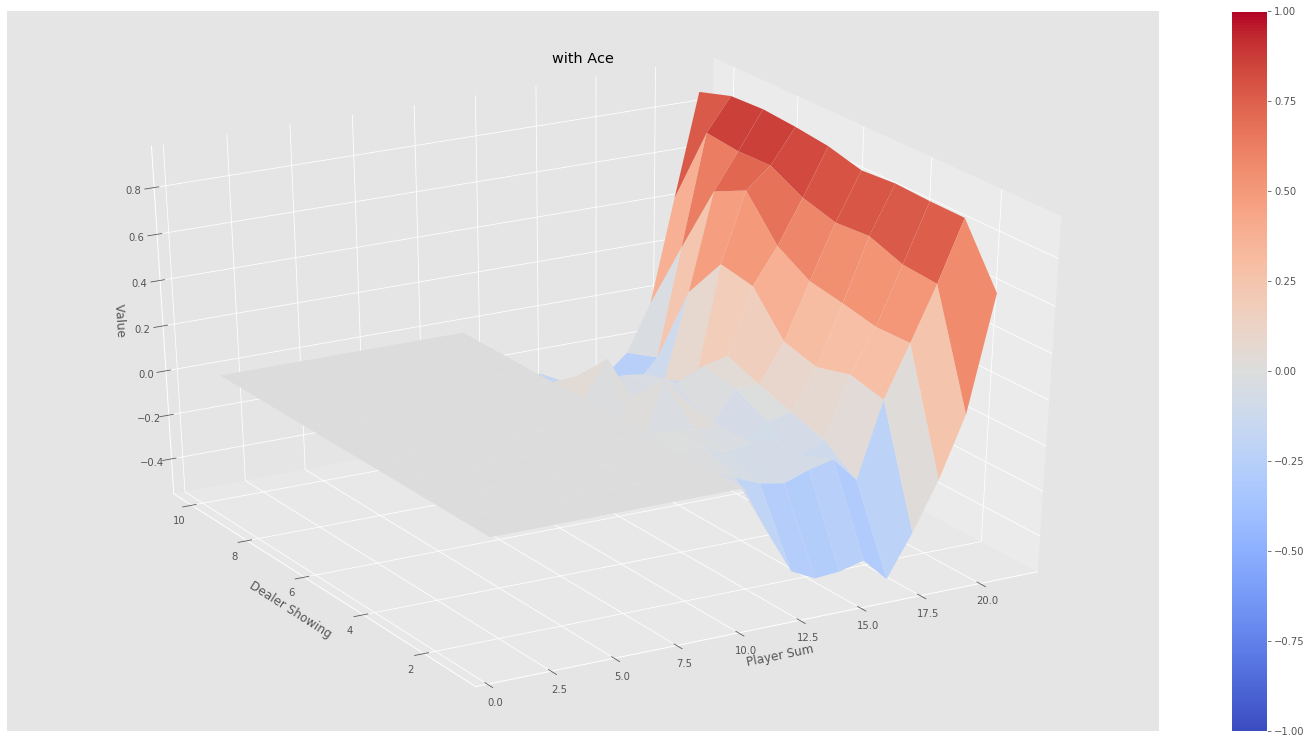

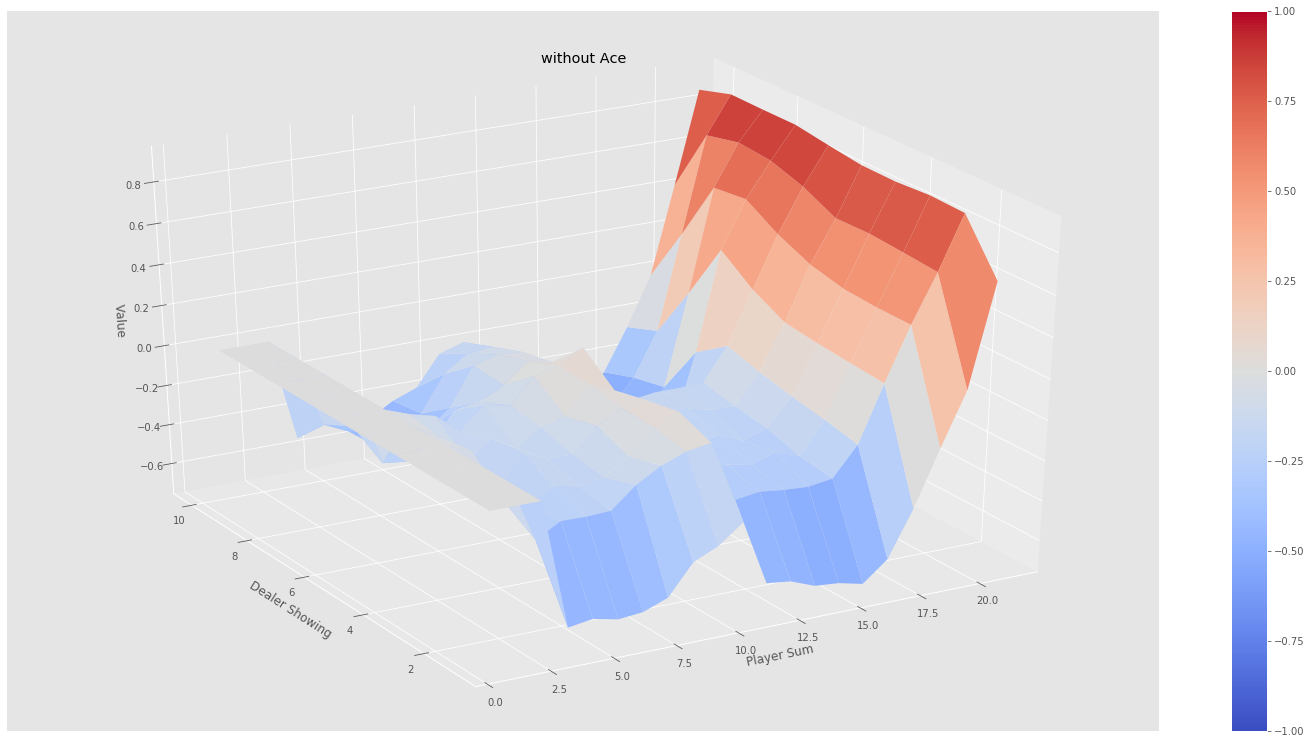

In [255]:
value_f = defaultdict(float)
for state in plot_Q:
    value_f[state] = max(plot_Q[state]) 

X, Y = np.meshgrid(np.arange(1, 22), np.arange(1, 11))
#Z = np.array([value_f[temp] for temp[0],temp[1] in zip(np.ravel(temp[0]), np.ravel(temp[1]))]).reshape(temp[0].shape)
Z = np.array([value_f[(x,y,True)] for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)
plot_surface(X, Y, Z, 'with Ace')

Z2 = np.array([value_f[(x,y,False)] for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)
plot_surface(X, Y, Z2, 'without Ace')

### Exercise 5 (10 pts):

Implement the below function to train an off-policy every-visit MC agent which uses weighted importance sampling. As before, the behavior policy should be the epsilon greedy action selection.

In [14]:
def random_sample_episode(env, Q, eps):
    """Sample an episode from the environment, using an epsilon-greedy policy based on Q.
    Args:
        env: The environment from which to sample episodes.
        Q: A dictionary mapping state -> action values array.
        eps: The epsilon-greedy parameter.
    
    Returns:
        transitions: A list of (state, action, reward) tuples describing the episode.
        
    Shapes:
        Q: `(A,)` Each value in Q is an array with shape `(A,)` where `A` is the number of actions.
    """
    transitions = []  # store (state, action, reward) tuples here

    state_act_prob = {}
    state = env.reset()
    done = False
    while done != True:
        state_Q_array = Q[state]
        
        num_actions = len(state_Q_array)
        initial_prob = np.ones(num_actions)
        random_prob = initial_prob * eps / num_actions
        opt_action = np.argmax(state_Q_array)
        random_prob[opt_action] = random_prob[opt_action] + (1-eps)
        action = np.random.choice(np.arange(num_actions), p = random_prob)
        
        state_act_prob[state] = random_prob
        
        the_action = select_action_epsilon_greedy(state_Q_array, eps)
        state_next, reward, done, info = env.step(the_action)
        transitions.append((state, the_action, reward))

        state = state_next
    
    return transitions, state_act_prob

In [12]:
def off_policy_every_visit_is_control(env, num_episodes, eps, gamma):
    '''
    Trains an off-policy every-visit MC agent with weighted importance sampling.
    
    Args:
        env: The environment to train the agent on.
        num_episodes: The number of episodes for which to train the agent.
        eps: The probability to select a random action. Float between 0 and 1.      
        gamma: The discount factor.
        
    Returns:
        Q is a dictionary mapping state -> action values array.
        returns is a list containing the rewards obtained for each episode during training.
    '''
    
    # Create Q function dict with default values, and C (the counts) dict with default values
    Q = defaultdict(lambda: np.zeros([env.action_space.n]))
    C = defaultdict(lambda: np.zeros([env.action_space.n], dtype=np.int))
    policy = defaultdict(int)
    
    G_queue = deque(maxlen=100)  # stores 100 most recent episode returns for diagnostics
    
    # Returns array to store episode performances
    returns = np.empty(num_episodes)

    pbar = tqdm.tnrange(num_episodes, leave=False)
    for i in pbar:
        G = 0.0
        W = 1.0
        # YOUR CODE HERE:  sample an episode using the epsilon-greedy policy,
        # and use the transition list to compute returns and update Q and C.
        
        the_episode, SA_prob = random_sample_episode(env, Q, eps)
        
        backward_list = range(len(the_episode))[::-1]
        for temp in backward_list:
            the_state, the_act, the_reward = the_episode[temp][0], the_episode[temp][1], the_episode[temp][2]
            G = gamma * G + the_reward
                        
            C[the_state][the_act] +=W
            Q[the_state][the_act] = Q[the_state][the_act] + W*(G - Q[the_state][the_act])/C[the_state][the_act]
            policy[the_state] = np.argmax(Q[the_state])
            if the_act != policy[the_state]:
                break
            
            W = W * 1/SA_prob[the_state][the_act]
            
        returns[i] = G
        
        # diagnostics
        G_queue.append(G)
        pbar.set_description(f'Episodes G={sum(G_queue) / len(G_queue)}')
            
    return Q, returns

### Exercise 6 (20 pts):

a) (5pts) Compute and plot the learning curve weighted importance sampling in the blackjack environment, averaging 50 runs of 5k episodes each.  Again, start with $\epsilon = 0.5$, and use the resulting plots to find a better $\epsilon$ with better convergence.  Compare the results to those shown in exercise (3c).

In [166]:
num_runs, num_episodes = 50, 5_000

returns_is = np.empty((num_runs, num_episodes))
for i in tqdm.tnrange(num_runs, desc='Runs (IS)'):
    Blackjack_Q_is, Blackjack_returns_is = off_policy_every_visit_is_control(env_blackjack, num_episodes, 0.5, 1)
    returns_is[i] = Blackjack_returns_is

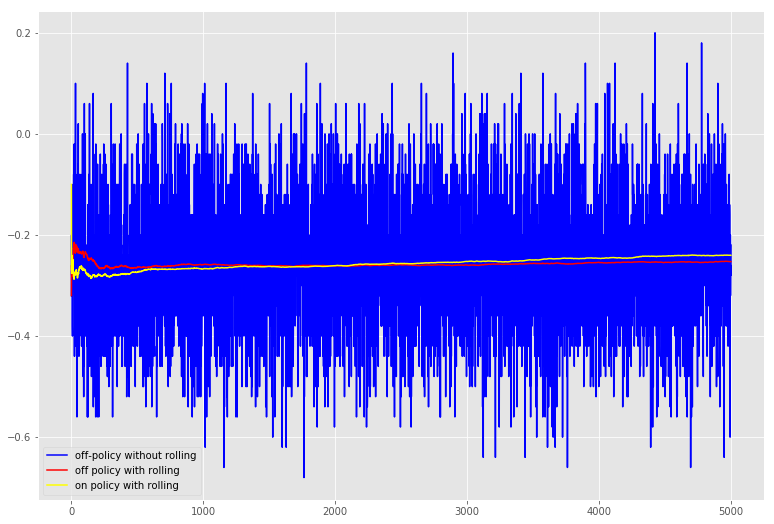

In [206]:
# YOUR CODE HERE
r_avg_is = np.average(returns_is, axis=0)
rolling_avg_is = rolling_average(r_avg_is, 2000)

plt.figure(figsize=(13,9))
plt.plot(r_avg_is, color = 'blue', label = 'off-policy without rolling')
plt.plot(rolling_avg_is, color = 'red', label = 'off policy with rolling')
plt.plot(rolling_avg2, color = 'yellow', label = 'on policy with rolling')
plt.legend()
plt.show()

**The on policy result of Blackjack is slightly better than off-policy result. It converges to a slightly larger return.**

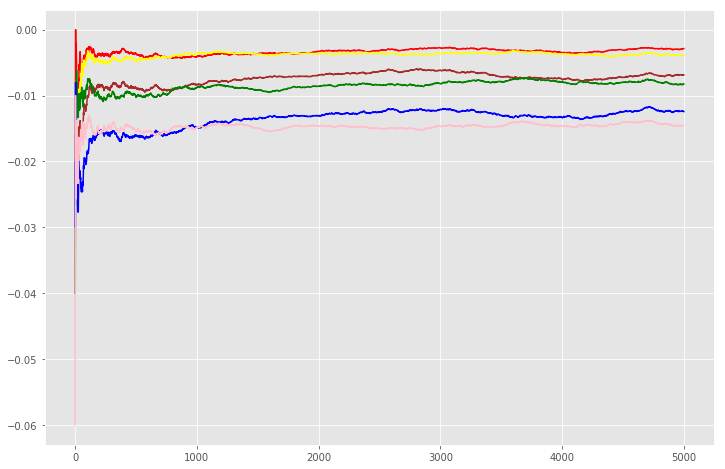

In [214]:
candidate_lambdas = [0.1, 0.2, 0.3, 0.4, 0.6, 0.7]
colors = ['red', 'yellow','brown','green', 'blue','pink']

plt.figure(figsize=(12, 8))
num_runs, num_episodes = 50, 5_000
for i in range(len(candidate_lambdas)):
    temp_returns_is = np.empty((num_runs, num_episodes))
    for k in tqdm.tnrange(num_runs, desc='Runs'):
        # YOUR CODE HERE
        Blackjack_temp_Q_is, Blackjack_temp_returns_is = off_policy_every_visit_is_control(env_blackjack, num_episodes, 
                                                                                    candidate_lambdas[i], 1)
        temp_returns_is[i] = Blackjack_temp_returns_is
        
    r_temp_avg = np.average(temp_returns_is, axis=0)
    temp_rolling_avg = rolling_average(r_temp_avg, 2000)
    #returns_temp_fl.append(temp_rolling_avg)
    plt.plot(temp_rolling_avg, color = colors[i])

plt.show()

In [15]:
num_runs, num_episodes = 50, 5_000

returns_is_better = np.empty((num_runs, num_episodes))
for i in tqdm.tnrange(num_runs, desc='Runs (IS)'):
    Blackjack_Q_is_better, Blackjack_returns_is_better = off_policy_every_visit_is_control(env_blackjack, num_episodes, 0.1, 1)
    returns_is_better[i] = Blackjack_returns_is_better

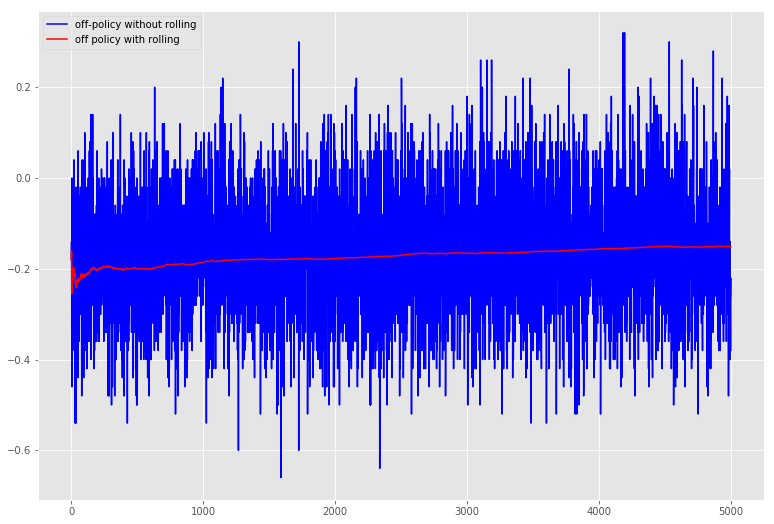

In [17]:
r_avg_is_better = np.average(returns_is_better, axis=0)
rolling_avg_is = rolling_average(r_avg_is_better, 2000)

plt.figure(figsize=(13,9))
plt.plot(r_avg_is_better, color = 'blue', label = 'off-policy without rolling')
plt.plot(rolling_avg_is, color = 'red', label = 'off policy with rolling')
plt.legend()
plt.show()

**Same as on policy result, 𝜖 parameter = 0.1 can give a better off policy result to converge for Blackjack environment.**

b) (5 pts) Now implement Monte Carlo Evaluation for the greddy policy of a Q function.

In [236]:
def on_policy_mc_evaluation(env, Q, num_episodes, gamma):
    '''
    Monte Carlo policy Evaluation.
    
    Args:
        env: The environment to train the agent on.
        Q is a dictionary mapping state -> action values array.
        num_episodes: The number of episodes for which to evaluate the agent.
        gamma: The discount factor.
        
    Returns:
        returns is a list containing the rewards obtained for each episode.
    '''
    returns = np.empty(num_episodes)

    pbar = tqdm.tnrange(num_episodes, leave=False)
    for i in pbar:
        # YOUR CODE HERE:  sample an episode using the epsilon-greedy policy,
        # and use the transition list to compute returns and update Q and C.
        eps = 0
        the_episode = sample_episode(env, Q, eps)
        
        G = 0.0
        
        backward_list = range(len(the_episode))[::-1]
        for temp in backward_list:
            the_reward = the_episode[temp][2]
            G = gamma * G + the_reward
            
        returns[i] = G
        
        
        pbar.set_description(f'Episodes G={G}')
            
    return returns

c) (5 pts) Now run off-policy every-visit Importance Sampling control for 50 runs and 10k episodes, with $\epsilon = 0.1$, and plot the returns as you did previously.  Then, evaluate the Q function obtained by one of the 50 runs using the on-policy evaluation function, and print the resulting returns' mean and standard deviation.

In [228]:
num_runs, num_episodes = 50, 10_000

returns_is2 = np.empty((num_runs, num_episodes))
for i in tqdm.tnrange(num_runs, desc='Runs (IS)'):
    Blackjack_Q_is2, Blackjack_returns_is2 = off_policy_every_visit_is_control(env_blackjack, num_episodes, 0.1, 1)
    returns_is2[i] = Blackjack_returns_is2

In [240]:
#Evaluate the last Q_value
evaluate_return = on_policy_mc_evaluation(env_blackjack, Blackjack_Q_is2, 5_000, 1)

In [241]:
eva_mean = np.mean(evaluate_return)
eva_std = np.std(evaluate_return)
print('The mean of the last Q_functon returns is ' + str(eva_mean) + ' and the standart deviation is ' + str(eva_std))

The mean of the last Q_functon returns is -0.0756 and the standart deviation is 0.9584803806025451


d) **[graduate]** (5 pts) Do the mean and std match what is shown in the plot you got in exercise (6a)?  If not, explain why they are different.



**I don't think it matches the mean and std in the 6a plot. The 6a shows the plot of using on-policy method to train policy. The off-policy uses weight therefore have a larger standard deviation and converges slower. Also on-policy have a better performance than off-policy method. That's why they are different.**